# Orchestration Agent: Report Generator

This Jupyter notebook demonstrates an orchestration agent utilizing LangGraph to generate a structured report on a specified topic. The agent orchestrates multiple steps:
1. Planning report sections
2. Writing content for each section
3. Compiling the final report
4. Outputting the report in markdown format

The workflow employs a `StateGraph` to manage shared state among nodes (agents). This example illustrates sequential orchestration, with an optional asynchronous parallel version for section writing.

**Key Concepts:**
- Shared state with `TypedDict`
- LLM-powered agents for planning, writing, and compiling
- Graph construction with nodes and edges
- Synchronous and asynchronous execution

Ensure you have an `OPENROUTER_API_KEY` environment variable set for the LLM to work.

## 1. Imports and State Definition

We start by importing necessary libraries from LangGraph, LangChain, and standard Python modules. The `ReportState` TypedDict defines the shared state that flows through the graph:
- `topic`: The main subject of the report.
- `sections`: List of section titles planned for the report.
- `section_drafts`: Dictionary mapping section titles to their generated content.
- `final_report`: The compiled markdown report.

This state ensures all agents can access and update relevant information.

In [ ]:
# Imports span typing hints, LangGraph orchestration, and LLM tooling.
from typing import TypedDict, List, Dict, Any
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage
import asyncio
from rich import print
import os
from langchain_ollama import ChatOllama, OllamaEmbeddings
from dotenv import load_dotenv
load_dotenv()
from langchain_community.llms import VLLM
from langchain_openai import ChatOpenAI


# TypedDict keeps the mutable LangGraph state structured and type-checked.
class ReportState(TypedDict):
    topic: str
    sections: List[str]  # This will be the list of section titles
    section_drafts: Dict[str, str]  # Maps section titles to their content
    final_report: str

## 2. LLM Initialization

Initialize the language model using `ChatOpenAI` configured for OpenRouter. This LLM will power all agents (planner, writer, compiler). Parameters like `temperature=0.7` control creativity, and `max_tokens=250` limits response length per call.

In [138]:
# Initialize the shared LLM that will power every agent in the workflow.
# llm = ChatOpenAI(
#     model='qwen/qwen3-30b-a3b-instruct-2507',  # OpenRouter-hosted model with strong reasoning skills.
#     base_url='https://openrouter.ai/api/v1',   # Direct requests through the OpenRouter endpoint.
#     temperature=0.7,                           # Allow moderate creativity for nuanced sections.
#     max_tokens=250,                            # Keep each response concise to control latency.
#     api_key=os.getenv('OPENROUTER_API_KEY')    # Pull the API key from environment variables.
# )
OLLAMA_BASE_URL = os.getenv('OLLAMA_BASE_URL', 'http://localhost:11434')
llm = ChatOllama(model='llama3.2:1b', base_url=OLLAMA_BASE_URL, temperature=0, max_tokens=150)

print(llm.invoke("What is the capital of France ?"))

AIMessage(
    content='The capital of France is Paris.',
    additional_kwargs={},
    response_metadata={
        'model': 'llama3.2:1b',
        'created_at': '2025-10-07T04:29:37.020967778Z',
        'done': True,
        'done_reason': 'stop',
        'total_duration': 78990396,
        'load_duration': 45176301,
        'prompt_eval_count': 32,
        'prompt_eval_duration': 10444024,
        'eval_count': 8,
        'eval_duration': 23120994,
        'model_name': 'llama3.2:1b'
    },
    id='run--aa7442a4-e2fd-4879-a7b5-14387780e368-0',
    usage_metadata={'input_tokens': 32, 'output_tokens': 8, 'total_tokens': 40}
)

## 3. Planner Agent

The `planner_agent` is the first node in the graph. It takes the report topic and uses the LLM to generate 3-4 logical section titles. The prompt instructs the LLM to output only titles, one per line, without numbering.

This agent updates the state with the `sections` list and initializes an empty `section_drafts` dict.

In [139]:
def planner_agent(state: ReportState) -> ReportState:
    """Plans the structure of the report by defining sections"""
    # Pull the topic from the shared state dictionary supplied by LangGraph.
    topic = state['topic']

    # Build a targeted prompt so the LLM returns only section headings.
    planning_prompt = f"""
    You are a report planning expert. Given the topic: "{topic}"
    
    Create a logical outline with 3-4 main sections for a comprehensive report.
    Return only the section titles, one per line, without numbering.
    
    Example format:
    Introduction and Background
    Current State Analysis
    Future Implications
    Conclusion and Recommendations
    """

    # Ask the LLM for candidate section titles based on the topic.
    response = llm.invoke([HumanMessage(content=planning_prompt)])
    # Split the multiline LLM response into a clean list of section names.
    sections = [line.strip() for line in response.content.strip().split('\n') if line.strip()]

    # Merge the new sections into state without mutating the original object.
    return {**state, 'sections': sections, 'section_drafts': {}}


## 4. Section Writer Helper

The `write_section` helper function generates content for a single section. It classifies the section type (e.g., introductory vs. strategic) to adjust the prompt's focus and tone. The LLM is prompted to write 2-3 paragraphs without including the title.

In [ ]:
def write_section(section_title: str, topic: str) -> str:
    """Helper function to write a single section"""
    # Simple heuristics tune the focus and tone based on the section name.
    # if section_title.lower() in ['introduction', 'background']: # Exact match for intro/background sections
    # could use llm to create focus and tone dynamically
    if any(keyword in section_title.lower() for keyword in ['introduction', 'background', 'analysis', 'current']):
        focus = 'research-backed information and analysis'
        tone = 'professional and factual'
    else: # All other sections get a more strategic and forward-looking approach.
        focus = 'strategic insights and actionable recommendations'
        tone = 'forward-thinking and suggestive'

    # Compose instructions that tell the LLM how to draft the section body.
    writer_prompt = f"""
    You are an expert report writer. Write a detailed section for a report on "{topic}".
    
    Section to write: "{section_title}"
    
    Requirements:
    - Write 2-3 substantial paragraphs.
    - Focus on {focus}.
    - Use a {tone}.
    - Do not include the section title itself in your response, just the content.
    """

    # Generate the section copy and trim whitespace before returning it.
    response = llm.invoke([HumanMessage(content=writer_prompt)])
    return response.content.strip()


## 5. Writer Coordinator

The `writer_coordinator` node orchestrates writing all sections by calling `write_section` for each title in sequence. It updates the state with the `section_drafts` dictionary.


In [141]:
def writer_coordinator(state: ReportState) -> ReportState:
    """Coordinates the writing of all sections"""
    topic = state['topic']
    sections = state['sections']
    # Create a fresh mapping so we do not mutate the incoming state in place.
    section_drafts = {}

    # Iterate sequentially through the planned sections and draft each one.
    for section_title in sections:
        section_content = write_section(section_title, topic)
        # Store the generated paragraphs under their corresponding title.
        section_drafts[section_title] = section_content

    return {**state, 'section_drafts': section_drafts}


## 6. Compiler Agent

The `compiler_agent` finalizes the report by formatting the sections into a markdown string with the topic as the title and each section as a heading followed by its content.


In [142]:
def compiler_agent(state: ReportState) -> ReportState:
    """Compiles all drafted sections into a final report"""
    topic = state['topic']
    section_drafts = state['section_drafts']
    sections = state['sections']

    # Start the markdown document with a descriptive heading for the topic.
    final_report_content = f'# Report: {topic}\n\n'

    # Walk through sections in outline order to preserve the planned flow.
    for section_title in sections:
        if section_title in section_drafts:
            # Append each section as markdown headings plus the generated body.
            final_report_content += f'## {section_title}\n\n{section_drafts[section_title]}\n\n'

    return {**state, 'final_report': final_report_content}


## 8. Graph Construction (Synchronous)

Build the `StateGraph` by adding nodes for each agent and defining edges for the sequential flow: planner → writer_coordinator → compiler → END.

Compile the graph into an app for invocation.

In [143]:
# --- Graph Construction ---

# Build the orchestration graph specifying each agent node and its edges.
workflow = StateGraph(ReportState)

# Add nodes that correspond to each stage of the reporting pipeline.
workflow.add_node('planner', planner_agent)
workflow.add_node('writer_coordinator', writer_coordinator)
workflow.add_node('compiler', compiler_agent)

# The planner kicks off the workflow by generating the report outline.
workflow.set_entry_point('planner')

# Connect nodes to define a simple linear progression.
workflow.add_edge('planner', 'writer_coordinator')
workflow.add_edge('writer_coordinator', 'compiler')
workflow.add_edge('compiler', END)

# Freeze the definition into an executable LangGraph app.
app = workflow.compile()


Subgraph structure:

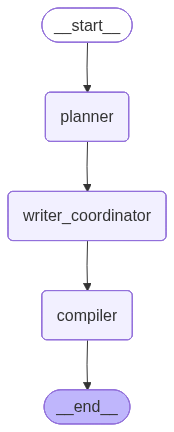

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xae\x00\x00\x01\xb0\x08\x02\x00\x00\x00\xbf\xc5\xc9\xe6\x00\x00\x10\x00IDATx\x9c\xec\x9d\x07\\\x14G\xfb\xc7g\xef\x0e\xb8\xa3\x0b\xd2\x8b\xd2, *\x06KL\x82&\xe8\xabF\x8d\xbd\xc5^\xde\x14\x8d\xc6\xd8b\xcd\x1b[\xf2&\x96\x18[\xd4\x18\xdfD\xa3\x7fc\xeci\xb6\x185v\x8d\r\xb1\x05\x01E)\n(\x9d\xab\xfb\x7f\xf6v9\x0e\xd8C\xce\x88\xbb\xb0\xcfW\xbc\xcf\xde\xccl\xb9\x99\xdf\xce<3;;\x8f\x82\xa6i\x82 \x84(\x08\x82\x18A) \x1c(\x05\x84\x03\xa5\x80p\xa0\x14\x10\x0e\x94\x02\xc2Q3\xa4p\xe3\xfc\xe3\xa4\xb8\xc2\x9c,\xadNM\xf4\x06\xa6\xf7+\x93Q\x06\xe3\x06%#\x14\xfc#\x84\xfb\n_(\x8a\xd6\xd34\x13\xc6\xc4\xd2\x06\xe6\x93\x81&\xe6\x1dgJF\x95\x04\xd2\xb0\x17\x1b%3\x06\xc2&]rpvw\xe3\'\xc5\x06\x96\xec\xce\x042\xbbP\x94\x01\x8eP\xf2\xd5\x84\\N\xd9\xd8QNn\x8az\x8d\xed#\xda\xb8\x12\xd1C\x89y\\\xe1\xe4\xde\x877/\xe4\x17\xe6\xe9\xa1\xa8\x146DnC)l\xe4\x94\xb1\x90\xd9\x82\xa1\x99\xc2cJ\x8e"\\I@J\xf8\x02r\x91\x11V\x0bL\xc12%\xcdn\x1b\xb8\x10\xe3\x11\xb8\xb3\xd0\xe5\x03\x99/\

In [144]:
print('Subgraph structure:')
# Visualize the compiled graph when graphviz support is available.
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))
# save to file

app.get_graph().draw_mermaid_png(output_file_path='graph.png')


## 10. Execution Functions

`generate_report` runs the synchronous graph to produce the final report. `generate_report_async` builds and runs an async version of the graph, using the parallel writer coordinator.


In [145]:
# --- Execution Functions ---
def generate_report(topic: str) -> str:
    """Generate a report using the sequential workflow."""
    # Seed the graph state with empty containers for sections and drafts.
    initial_state = {'topic': topic, 'sections': [], 'section_drafts': {}, 'final_report': ''}
    # debug=True prints each node transition for instructional purposes.
    result = app.invoke(initial_state, debug=True)
    return result['final_report']


## 11. Running the Example

The main execution generates a sample report on 'The Impact of Artificial Intelligence on Healthcare' using the synchronous function. For async, uncomment and run with `asyncio.run`.


In [146]:
# Choose a sample topic to demonstrate the orchestration pipeline.
topic = 'The Impact of Artificial Intelligence on Healthcare'

# Generate the report synchronously so we can inspect the output immediately.
print(f'Generating report on: {topic}...')
report = generate_report(topic)
print(report)


Generating report on: The Impact of Artificial Intelligence on Healthcare...

[values] {'topic': 'The Impact of Artificial Intelligence on Healthcare', 'sections': [], 'section_drafts': {}, 'final_report': ''}
[updates] {'planner': {'topic': 'The Impact of Artificial Intelligence on Healthcare', 'sections': ['Here is a logical outline for a comprehensive report on "The Impact of Artificial Intelligence on Healthcare":', 'Introduction and Background', 'Current State Analysis', 'Future Implications', 'Healthcare Industry Transformation', 'Research Methodology and Data Sources', 'Data Analysis and Insights', 'Challenges and Limitations', 'Recommendations for Future Development', 'Implementation Roadmap and Timeline'], 'section_drafts': {}, 'final_report': ''}}
[values] {'topic': 'The Impact of Artificial Intelligence on Healthcare', 'sections': ['Here is a logical outline for a comprehensive report on "The Impact of Artificial Intelligence on Healthcare":', 'Introduction and Background', 'Current State Analysis', 'Future Implications', 'Healthcare Industry Transfor

# Report: The Impact of Artificial Intelligence on Healthcare

## Here is a logical outline for a comprehensive report on "The Impact of Artificial Intelligence on Healthcare":

**The Impact of Artificial Intelligence on Healthcare: Strategic Insights and Recommendations**

Artificial intelligence (AI) has revolutionized various industries, including healthcare, by transforming the way 
medical professionals diagnose, treat, and manage patients. The integration of AI technologies into healthcare 
systems has led to significant improvements in patient outcomes, reduced costs, and enhanced operational 
efficiency. However, as AI continues to advance, it is essential for healthcare organizations to understand its 
strategic implications and develop actionable recommendations to maximize its benefits.

One of the primary strategic insights emerging from the adoption of AI in healthcare is the need for a 
multidisciplinary approach to implementation. Healthcare providers must collaborate with IT professionals, data 
scientists, and medical experts to design and deploy AI-powered solutions that meet specific clinical needs. This 
requires a shift from a traditional, rule-based approach to a more flexible, adaptive framework that can 
accommodate the rapidly evolving nature of healthcare. By fostering partnerships between different stakeholders, 
organizations can leverage AI's strengths in pattern recognition, predictive analytics, and decision support to 
improve patient care.

To maximize the impact of AI on healthcare, organizations must also prioritize data-driven decision-making. The 
collection, analysis, and interpretation of large datasets are critical components of AI implementation. Healthcare
providers should invest in robust data infrastructure, including cloud-based storage solutions and advanced 
analytics tools, to ensure that they can extract meaningful insights from their data. Additionally, organizations 
should establish clear guidelines for data sharing, security, and governance to prevent the misuse of patient 
information and maintain trust with patients and regulatory bodies.

Furthermore, AI has the potential to transform healthcare delivery models by enabling personalized medicine, 
improving population health management, and enhancing care coordination. For instance, AI-powered predictive 
analytics can help identify high-risk patients, predict disease progression, and optimize treatment plans. By 
leveraging these capabilities, healthcare providers can reduce hospital readmissions, improve patient outcomes, and
decrease costs associated with chronic diseases.

In conclusion, the integration of AI in healthcare has far-reaching strategic implications that require careful 
consideration and strategic planning. By fostering partnerships, prioritizing data-driven decision-making, and 
investing in robust infrastructure, organizations can unlock the full potential of AI to transform patient care and
drive business success. As AI continues to evolve, it is essential for healthcare providers to stay ahead of the 
curve by embracing this transformative technology and developing actionable recommendations that support its 
adoption and effective implementation.

## Introduction and Background

The integration of artificial intelligence (AI) into healthcare has been a rapidly evolving field in recent years. 
As AI technology advances at an unprecedented rate, its applications are expanding beyond the realm of computer 
vision and natural language processing to tackle complex clinical problems that have long plagued the industry.

One of the primary drivers behind the adoption of AI in healthcare is the need for more efficient and effective 
diagnosis and treatment processes. Studies have shown that AI-powered algorithms can analyze large amounts of 
medical data, including electronic health records (EHRs), genomic information, and imaging studies, to identify 
patterns and anomalies that may indicate a patient's con